In [23]:
# imports
from datascience import *
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [24]:
# Dataset 1
epl_players = pd.read_csv("epldata_final.csv")
epl_players.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [25]:
#Helper methods to get distributions for different categories of player variables in the dataframe
def record_one_distribution(epl_players, match_column, match_value, record_column):
    return epl_players[epl_players[match_column] == match_value][record_column].tolist()

def record_all_distributions(epl_players, match_column, record_column):
    unique_values = epl_players[match_column].unique().tolist()
    distributions = {}
    
    for match_value in unique_values:
        distributions[match_value] = record_one_distribution(epl_players, match_column, match_value, record_column)
    return distributions

# Record distributions in dictionaries
clubs_to_market_val = record_all_distributions(epl_players, "club", "market_value")

clubs_to_page_views = record_all_distributions(epl_players, "club", "page_views")

positions_to_market_val = record_all_distributions(epl_players, "position", "market_value")


In [26]:
random_sample_one = epl_players.sample(100)
random_sample_two = epl_players.sample(150)


## Testing Hypothesis

Null Hypothesis: The difference in the average market value of players who play in LW and CF positions is only a chance.

Alternative Hypothesis: The difference in the average market value of players who play in LW and CF positions is not chance but the effect of some variables like deliberate less valuation for one position than the other.

## Test Statistic
For each of the bootstraped sample, we will calculate the average market value of players for both the positions and compute their difference. This test statistic will help us explore the difference we see in the randomly selected sample.

## Observed Value
Oberved value of the test statistics is:

In [27]:
def market_val_avg_diff(distribution, group_one, group_two):
    avg_one = sum(distribution[group_one])/len(distribution[group_one])
    avg_two = sum(distribution[group_two])/len(distribution[group_two])
    return avg_one-avg_two

observed_stat = market_val_avg_diff(positions_to_market_val, "LW", "CF")
print(observed_stat)

-0.5307149362477226


## Bootstraping

In [28]:
def resample(first_sample, num_resamples, group_one, group_two):
    avg_market_value_diff = []
    for i in range(num_resamples):
        resample = first_sample.sample(frac=1, replace=True)
        
        # Createa dictionary distribution from resample
        resample_positions_to_market_val = record_all_distributions(resample, "position", "market_value")
        
        avg_market_value_diff.append(market_val_avg_diff(resample_positions_to_market_val, group_one, group_two))
    return avg_market_value_diff
        

In [29]:
resample_distributions = resample(random_sample_two, 150, "LW", "CF")


In [30]:
# Calculate p-value
empirical_more_than_observed_count = 0

for item in resample_distributions:
    if item >= observed_stat:
        empirical_more_than_observed_count += 1
        
p_value = empirical_more_than_observed_count / len(resample_distributions)
print("P-value: ", p_value)

P-value:  0.02666666666666667


The p-value is way bigger than 0.05 cutoff which means that the alternative hypothesis is favored over null hypothesis. This means that the average market value of players playing in LW and CF positions is not a random chance but the effect of some variable.

# Correlation and Linear Regression

In [31]:
def standard_units(arr):
    arr_mean = arr.mean()
    arr_std = arr.std()
    
    arr_standard_unit = []
    for item in arr:
        arr_standard_unit.append((item - arr_mean) / arr_std)
    return arr_standard_unit

In [32]:
# Standard units for columns of importance

age_su = standard_units(epl_players["age"])
market_value_su = standard_units(epl_players["market_value"])
page_views_su = standard_units(epl_players["page_views"])
fpl_value_su = standard_units(epl_players["fpl_value"])

In [33]:
def plot_scatter(x_values, y_values, title, xlabel, ylabel):
    plt.scatter(x_values, y_values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

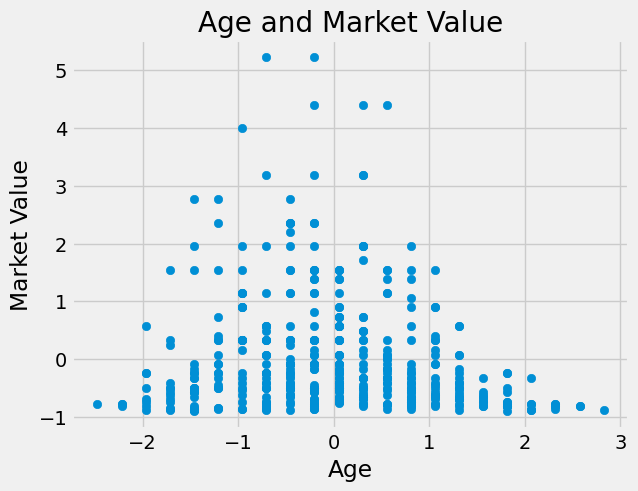

In [34]:
plot_scatter(age_su, market_value_su, "Age and Market Value", "Age", "Market Value")

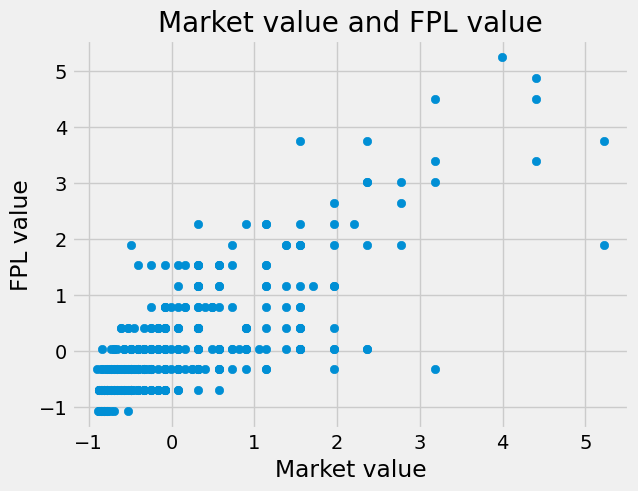

In [35]:
plot_scatter(market_value_su, fpl_value_su, "Market value and FPL value", "Market value", "FPL value")

## Correlation calculations

In [36]:
def correlation(arr1, arr2):
    arr_one_su = standard_units(arr1)
    arr_two_su = standard_units(arr2)
    length = len(arr_one_su)
    products = []
    
    for i in range(length):
        products.append(arr_one_su[i] * arr_two_su[i])
    return sum(products)/length

In [37]:
corr_age_market_val = correlation(epl_players["age"], epl_players["market_value"])
corr_market_val_fpl_val = correlation(epl_players["market_value"], epl_players["fpl_value"])
corr_page_views_market_val = correlation(epl_players["page_views"], epl_players["market_value"])

print("Correlations:")
print("Age and Market Value: ", corr_age_market_val)
print("Market Value and Fantasy Premier League value: ", corr_market_val_fpl_val)
print("Page Views and Market Value: ", corr_page_views_market_val)

Correlations:
Age and Market Value:  -0.132109037933
Market Value and Fantasy Premier League value:  0.786942667623
Page Views and Market Value:  0.738052063919


## Regression parameters from Correlation

In [38]:
# Regression parameters using correlation
def regression_parameters(x, y):
    correlation_val = correlation(x, y)
    slope = correlation_val * y.std() / x.std()
    intercept = (sum(y)/len(y)) - (slope * (sum(x)/len(x)))
    return [slope, intercept]


In [39]:
param_age_market_val = regression_parameters(epl_players["age"], epl_players["market_value"])
param_market_val_fpl_val = regression_parameters(epl_players["market_value"], epl_players["fpl_value"])
param_page_views_market_val = regression_parameters(epl_players["page_views"], epl_players["market_value"])

print("Parameters (slope, intercept):")
print("Age and Market Value: ", param_age_market_val)
print("Market Value and Fantasy Premier League value: ", param_market_val_fpl_val)
print("Page Views and Market Value: ", param_page_views_market_val)

Parameters (slope, intercept):
Age and Market Value:  [-0.40872235369576776, 21.967748643424297]
Market Value and Fantasy Premier League value:  [0.086459747972030307, 4.4958411419362028]
Page Views and Market Value:  [0.0097086773965931964, 3.5967786984428161]


## Scatter plots with regression line

In [40]:
def plot_scatter_and_line(x_values, y_values, title, xlabel, ylabel, slope, intercept):
    highest_x = int(max(x_values))
    lowest_x = int(min(x_values))
    
    line_x_values = []
    line_y_values = []
    
    for i in range(lowest_x, highest_x, 1):
        y = (slope * i) + intercept
        line_x_values.append(i)
        line_y_values.append(y)
    
    plt.scatter(x_values, y_values)
    plt.plot(line_x_values, line_y_values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

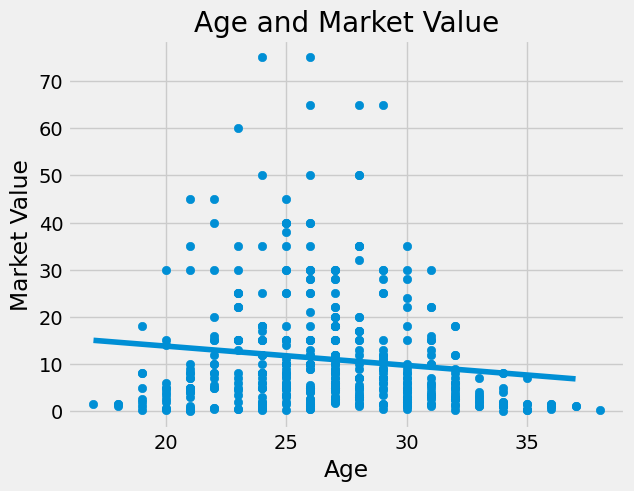

In [41]:
plot_scatter_and_line(epl_players["age"], epl_players["market_value"], "Age and Market Value", "Age", "Market Value", param_age_market_val[0], param_age_market_val[1])


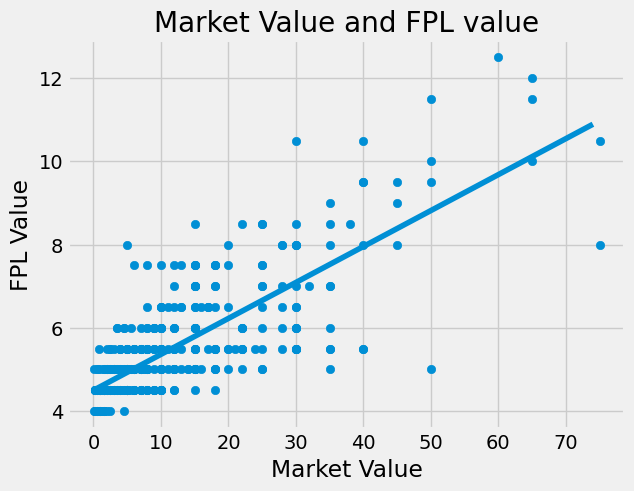

In [42]:
plot_scatter_and_line(epl_players["market_value"], epl_players["fpl_value"], "Market Value and FPL value", "Market Value", "FPL Value", param_market_val_fpl_val[0], param_market_val_fpl_val[1])


## Regression line minimizing RMSE

In [43]:
def RMSE(slope, intercept):
    x_values = epl_players["page_views"]
    y_values = epl_players["market_value"]
    predicted_y_values = [(x * slope + intercept) for x in x_values]
    squared_errors = [((y_values[i] - predicted_y_values[i])**2) for i in range(len(y_values))]
    mean_squared_error = sum(squared_errors)/len(squared_errors)
    return (mean_squared_error ** (0.5))

minimized_parameters = minimize(RMSE, smooth=True)
print("Slope and intercept using minimization of RMSE method: ", minimized_parameters)

Slope and intercept using minimization of RMSE method:  [ 0.00972977  3.58066516]


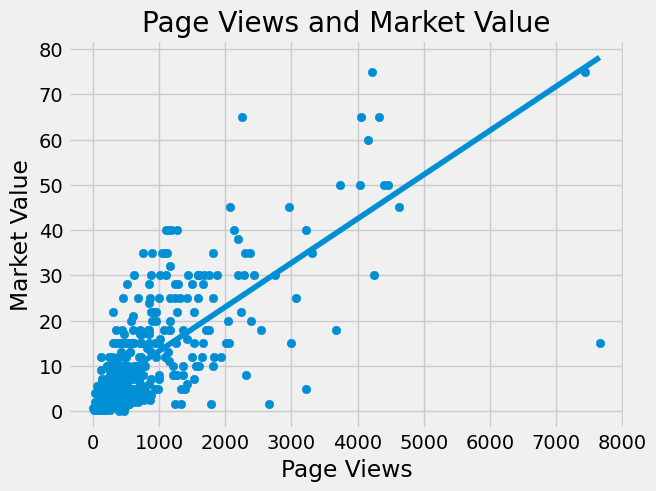

In [44]:
plot_scatter_and_line(epl_players["page_views"], epl_players["market_value"], "Page Views and Market Value", "Page Views", "Market Value", minimized_parameters[0], minimized_parameters[1])


## Correlation and Regression Conclusion
The slope and intercept parameters using correlation are almost equal to the parameters obtained using minimization of RMSE method. The line of best fit therefore appears exactly the same.

From both the correlation values and the regression line in, we can conclude that the second and third relations have strong correlation. The first relation of age amd markeet value has negative correlation and regression line is inclined towards the right. 